<a href="https://colab.research.google.com/github/MTufekcioglu/Personal-Projects/blob/main/nanoGPTshakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tiktoken
!pip install transformers
!pip install plotly
!git clone https://github.com/karpathy/nanoGPT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.6 MB/s eta 0:00:00
Cloning into 'nanoGPT'...
remote: Enumerating objects: 682, done.
remote: Total 682 (delta 0), reused 0 (delta 0), pack-reused 682 (from 1)
Receiving objects: 100% (682/682), 952.47 KiB | 3.23 MiB/s, done.
Resolving deltas: 100% (385/385), done.


In [2]:
import torch
from nanoGPT.model import GPT
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
import random
import os

In [3]:
!cd ./nanoGPT/data/shakespeare/ && python prepare.py

train has 301,966 tokens
val has 36,059 tokens


In [5]:
!cd ./nanoGPT/ && python train.py --dtype=float16 --dataset=shakespeare --compile=False --n_layer=4 --n_head=4 --n_embd=64 --block_size=64 --batch_size=8 --init_from=gpt2 --eval_interval=100 --eval_iters=100 --max_iters=100 --bias=True

Overriding: dtype = float16
Overriding: dataset = shakespeare
Overriding: compile = False
Overriding: n_layer = 4
Overriding: n_head = 4
Overriding: n_embd = 64
Overriding: block_size = 64
Overriding: batch_size = 8
Overriding: init_from = gpt2
Overriding: eval_interval = 100
Overriding: eval_iters = 100
Overriding: max_iters = 100
Overriding: bias = True
tokens per iteration will be: 20,480
Initializing from OpenAI GPT-2 weights: gpt2
loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M
config.json: 100% 665/665 [00:00<00:00, 4.37MB/s]
model.safetensors: 100% 548M/548M [00:02<00:00, 237MB/s]
generation_config.json: 100% 124/124 [00:00<00:00, 857kB/s]
/content/nanoGPT/train.py:196: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
num decayed 

In [6]:
model_path = "./nanoGPT"  # Corrected path to checkpoint file
ckpt = torch.load(model_path + '/out/ckpt.pt', map_location=torch.device('cpu')) # Load the checkpoint
model = ckpt['model']
optimizer = ckpt['optimizer']
model_args = ckpt['model_args']
iter_num = ckpt['iter_num']
best_val_loss = ckpt['best_val_loss']
config = ckpt['config']

<ipython-input-6-78737fce9412>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path + '/out/ckpt.pt', map_location=torch.device('cpu')) # Load the c

In [7]:
model_args

{'n_layer': 12,
 'n_head': 12,
 'n_embd': 768,
 'block_size': 64,
 'bias': True,
 'vocab_size': 50257,
 'dropout': 0.0}

In [8]:
model.keys()

odict_keys(['transformer.wte.weight', 'transformer.wpe.weight', 'transformer.h.0.ln_1.weight', 'transformer.h.0.ln_1.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.ln_2.weight', 'transformer.h.0.ln_2.bias', 'transformer.h.0.mlp.c_fc.weight', 'transformer.h.0.mlp.c_fc.bias', 'transformer.h.0.mlp.c_proj.weight', 'transformer.h.0.mlp.c_proj.bias', 'transformer.h.1.ln_1.weight', 'transformer.h.1.ln_1.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.ln_2.weight', 'transformer.h.1.ln_2.bias', 'transformer.h.1.mlp.c_fc.weight', 'transformer.h.1.mlp.c_fc.bias', 'transformer.h.1.mlp.c_proj.weight', 'transformer.h.1.mlp.c_proj.bias', 'transformer.h.2.ln_1.weight', 'transformer.h.2.ln_1.bias', 'transformer.h.2.attn.c_attn.weight', 'transformer.h.2.attn.

In [9]:
def calculate_sparsities(model, threshold = 0.1):
    layers = []


    for name in model.keys():
        param = model[name]
        if 'weight' in name and 'h.' in name:  # Filter for layer weights
            if 'attn' in name:
                layer_type = 'attn'
            elif 'mlp' in name:
                layer_type = 'mlp'
            elif 'ln' in name:
                layer_type = 'ln'
            else:
                layer_type = 'other'
            # Analyze the sparsity of 'param' tensor here
            layer_name = int(name.split('.')[2])  # Extract layer number (e.g., '0', '1')
            param_np = param.detach().cpu().numpy()
            sparsity = np.sum(np.abs(param_np) < threshold) / param_np.size
            layers.append((layer_name, layer_type, sparsity))
    return(layers)

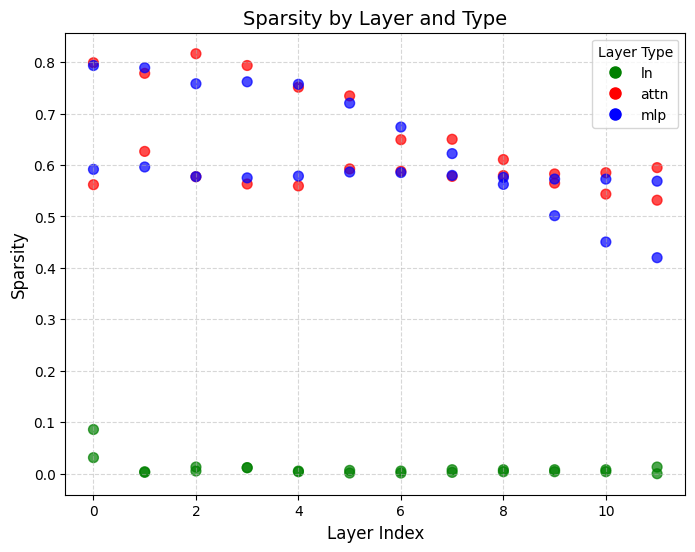

In [10]:
layers = calculate_sparsities(model, 0.1)
layers[:15]

x_values = [layer[0] for layer in layers]
y_values = [layer[2] for layer in layers]
layer_types = [layer[1] for layer in layers]
layer_type_colors = {
    'ln': 'green',
    'attn': 'red',
    'mlp': 'blue'
}

# Create scatter plot with enhancements
plt.figure(figsize=(8, 6))  # Adjust figure size
colors = [layer_type_colors.get(layer_type, 'gray') for layer_type in layer_types]
plt.scatter(x_values, y_values, c=colors, s=50, marker='o', alpha=0.7)  # Enhancements

# Set labels and title
plt.xlabel("Layer Index", fontsize=12)  # Increase font size
plt.ylabel("Sparsity", fontsize=12)
plt.title("Sparsity by Layer and Type", fontsize=14)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)  # Customize gridlines

# Add legend with custom colors and markers
handles = [plt.Line2D([], [], color=color, marker='o', linestyle='None',
                      markersize=8, label=layer_type)
           for layer_type, color in layer_type_colors.items()]
plt.legend(handles=handles, title="Layer Type", fontsize=10)

# Show plot
plt.show()

In [11]:
thresholds = np.linspace(0.025, 0.2, 8)
sparsities = []
for threshold in thresholds:
  sparsities.append(calculate_sparsities(model, threshold))

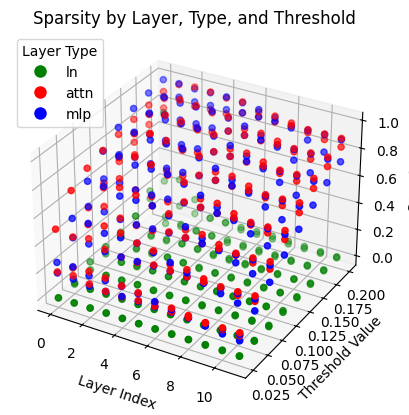

In [12]:
# Prepare data
x_values = []
y_values = []
z_values = []
layer_types = []
threshold_values = []  # To store unique threshold values

for i, threshold_data in enumerate(sparsities):  # Iterate through threshold data
    threshold_values.append(thresholds[i])  # Assuming threshold index corresponds to threshold value
    for layer in threshold_data:
        x_values.append(int(layer[0]))
        y_values.append(thresholds[i])  # Use threshold index as y-value
        z_values.append(layer[2])
        layer_types.append(layer[1])

# Define color mapping
layer_type_colors = {
    'ln': 'green',
    'attn': 'red',
    'mlp': 'blue'
}

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = [layer_type_colors.get(layer_type, 'gray') for layer_type in layer_types]
ax.scatter(x_values, y_values, z_values, c=colors)

# Set labels and title
ax.set_xlabel("Layer Index")
ax.set_ylabel("Threshold Value")
ax.set_zlabel("Sparsity")
ax.set_title("Sparsity by Layer, Type, and Threshold")

# Add legend
handles = [plt.Line2D([], [], color=color, marker='o', linestyle='None',
                      markersize=8, label=layer_type)
           for layer_type, color in layer_type_colors.items()]
ax.legend(handles=handles, title="Layer Type")

# Show plot
plt.show()

In [13]:
# Assuming sparsities is a list of lists with the same structure as layers
# sparsities = [[('0', 'ln', 0.0859375), ...], [('0', 'ln', 0.07), ...], ...]

# Prepare data
x_values = []
y_values = []
z_values = []
layer_types = []
threshold_values = []  # To store unique threshold values

for i, threshold_data in enumerate(sparsities):  # Iterate through threshold data
    threshold_values.append(thresholds[i])  # Assuming threshold index corresponds to threshold value
    for layer in threshold_data:
        x_values.append(int(layer[0]))
        y_values.append(thresholds[i])  # Use threshold index as y-value
        z_values.append(layer[2])
        layer_types.append(layer[1])

# Define color mapping
layer_type_colors = {
    'ln': 'green',
    'attn': 'red',
    'mlp': 'blue'
}

# Create interactive scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x_values,
    y=y_values,
    z=z_values,
    mode='markers',
    marker=dict(
        size=5,
        color=colors,                # set color to be 'color'
        colorscale='Rainbow',  # one of plotly colorscales
        opacity=0.8
    )
)])

# Set layout
fig.update_layout(
    title="Sparsity by Layer, Type, and Threshold",
    scene=dict(
        xaxis_title="Layer Index",
        yaxis_title="Threshold Value",
        zaxis_title="Sparsity"
    ),
    legend_title_text="Layer Type"
)

# Show plot
fig.show()

In [15]:
def sparsify_model(model, threshold=0.1, sparsification_rate=0.5):
    """Sparsifies the model by randomly setting a percentage of weights
    below the threshold to zero.
    """
    for name in model.keys():
        if 'weight' in name and 'h.' in name:  # Target layer weights
            param = model[name]
            mask = torch.abs(param) < threshold
            indices = torch.nonzero(mask)

            num_to_sparsify = int(sparsification_rate * indices.shape[0])
            if num_to_sparsify > 0:  # Check if there's something to sparsify
                selected_indices = indices[torch.randperm(indices.shape[0])[:num_to_sparsify]]

                with torch.no_grad():  # No gradient tracking for in-place modifications
                    if param.dim() == 2 and param.shape[1] > 1:
                        param[selected_indices[:, 0], selected_indices[:, 1]] = 0.0  # For 2D tensors
                    else:
                        param[selected_indices[:, 0]] = 0.0  # For 1D or special cases

    return model

In [16]:
sparsified_model = sparsify_model(model, threshold=0.1, sparsification_rate=0.5)
os.rename('nanoGPT/out/ckpt.pt', 'nanoGPT/out/original.pt')
torch.save({'model': sparsified_model,
            'optimizer': optimizer,
            'model_args': model_args,
            'iter_num': iter_num,
            'config': config
            }, 'nanoGPT/out/ckpt.pt')

In [18]:
# Switch to original
os.rename('nanoGPT/out/ckpt.pt', 'nanoGPT/out/sparsified.pt')
os.rename('nanoGPT/out/original.pt', 'nanoGPT/out/ckpt.pt')

In [ ]:
# Switch to sparsified
os.rename('nanoGPT/out/ckpt.pt', 'nanoGPT/out/original.pt')
os.rename('nanoGPT/out/sparsified.pt', 'nanoGPT/out/ckpt.pt')

In [ ]:
!cd ./nanoGPT && python bench.py --dtype=float16 --compile=False --n_layer=4 --n_head=4 --n_embd=64 --block_size=64 --batch_size=8 --init_from=gpt2 --eval_interval=100 --eval_iters=100 --max_iters=100 --bias=True

In [19]:
!cd ./nanoGPT && python sample.py --dtype=float16 --num_samples=5 --max_new_tokens=10 --start="to be"

Overriding: dtype = float16
Overriding: num_samples = 5
Overriding: max_new_tokens = 10
Overriding: start = to be
/content/nanoGPT/sample.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi